In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

# ModernBERT example

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)

In [ ]:
text = "The capital of France is [MASK]."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

# To get predictions for the mask:
masked_index = inputs["input_ids"][0].tolist().index(tokenizer.mask_token_id)
predicted_token_id = outputs.logits[0, masked_index].argmax(axis=-1)
predicted_token = tokenizer.decode(predicted_token_id)
print("Predicted token:", predicted_token)

# Data preparation

In [4]:
import pandas as pd
import numpy as np
import torch

In [ ]:
# Load pd_train
pd_train = pd.read_csv("data_smiles/Training_Group.csv")
pd_train["label"] = pd_train["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)
pd_train.head()

In [ ]:
# Load pd_test
pd_test = pd.read_csv("data_smiles/Testing_Group.csv")
pd_test["label"] = pd_test["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)
pd_test.head()

In [ ]:
def encode_smiles(smiles_list):
    """
    Tokenize and encode a list of SMILES strings using ModernBERT.

    Args:
        smiles_list (list): List of SMILES strings.

    Returns:
        np.ndarray: Embeddings for the input SMILES strings.
    """
    embeddings_list = []

    for smiles in smiles_list:
        # Tokenize SMILES string
        inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)

        # Generate logits (embeddings)
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.logits.mean(dim=1)  # Average pooling over logits
            embeddings_list.append(embeddings.squeeze(0).detach().numpy())

    # Convert list of embeddings to a NumPy array
    return np.array(embeddings_list)

In [ ]:
# Encode SMILES train and test
X_train = encode_smiles(pd_train["Smiles"].to_list())
X_test = encode_smiles(pd_test["Smiles"].to_list())
y_train = pd_train["label"].values
y_test = pd_test["label"].values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

In [ ]:
# Save data to .npy files
np.save("modern_bert_data/X_train.npy", X_train)
np.save("modern_bert_data/X_test.npy", X_test)
np.save("modern_bert_data/y_train.npy", y_train)
np.save("modern_bert_data/y_test.npy", y_test)

print("Data saved successfully!")

# Model training

In [16]:
from pprint import pprint
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)

In [6]:
# load data
X_train = np.load("modern_bert_data/X_train.npy")
X_test = np.load("modern_bert_data/X_test.npy")
y_train = np.load("modern_bert_data/y_train.npy")
y_test = np.load("modern_bert_data/y_test.npy")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1241, 50368)
X_test shape: (286, 50368)
y_train shape: (1241,)
y_test shape: (286,)


In [12]:
def find_optimal_threshold(y_true, y_pred_proba):
    """
    Find optimal threshold based on sensitivity >= 0.7 or best F1 score.
    """
    best_threshold = 0.5
    best_metrics = {
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "sensitivity": 0,
        "specificity": 0,
        "f1": 0,
    }

    for threshold in np.arange(0.0, 1.0, 0.01):
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Calculate metrics
        auc = roc_auc_score(y_true, y_pred_proba)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = f1_score(y_true, y_pred)

        if sensitivity >= 0.7 or f1 > best_metrics["f1"]:
            best_threshold = threshold
            best_metrics = {
                "auc": auc,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "sensitivity": sensitivity,
                "specificity": specificity,
                "f1": f1,
            }

    return best_threshold, best_metrics

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
best_threshold, best_metrics = find_optimal_threshold(
    y_test, clf.predict_proba(X_test)[:, 1]
)

In [19]:
print("Best threshold:", best_threshold)
pprint(best_metrics)

Best threshold: 0.46
{'accuracy': 0.7097902097902098,
 'auc': 0.6446223459798119,
 'f1': 0.8065268065268065,
 'precision': 0.8317307692307693,
 'recall': 0.7828054298642534,
 'sensitivity': 0.7828054298642534,
 'specificity': 0.46153846153846156}


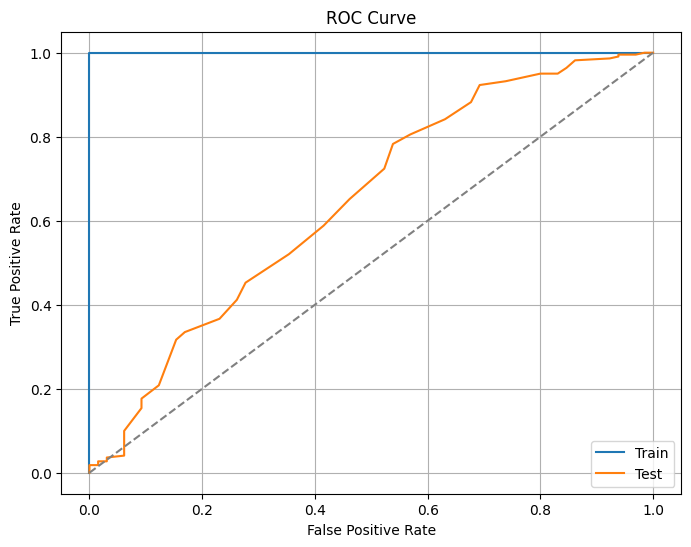

In [18]:
# plot auc train, test
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label="Train")
plt.plot(fpr_test, tpr_test, label="Test")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()